# Gradient Descent

In this section we are going to introduce the basic concepts underlying gradient descent. This is brief by necessity. See e.g. :cite:Boyd.Vandenberghe.2004 for an in-depth introduction to convex optimization. Although the latter is rarely used directly in deep learning, an understanding of gradient descent is key to understanding stochastic gradient descent algorithms. For instance, the optimization problem might diverge due to an overly large learning rate. This phenomenon can already be seen in gradient descent. Likewise, preconditioning is a common technique in gradient descent and carries over to more advanced algorithms. Let's start with a simple special case.

## Gradient Descent in One Dimension


Gradient descent in one dimension is an excellent example to explain why the gradient descent algorithm may reduce the value of the objective function. Consider some continously differentiable real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$. Using a Taylor expansion (:numref:chapter_math) we obtain that

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + O(\epsilon^2).$$ :eqlabel:gd-taylor

That is, in first approximation $f(x+\epsilon)$ is given by the function value $f(x)$ and the first derivative $f'(x)$ at $x$. It is not unreasonable to assume that for small $\epsilon$ moving in the direction of the negative gradient will decrease $f$. To keep things simple we pick a fixed step size $\eta > 0$ and choose $\epsilon = -\eta f'(x)$. Plugging this into the Taylor expansion above we get

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + O(\eta^2 f'^2(x)).$$

If the derivative $f'(x) \neq 0$ does not vanish we make progress since $\eta f'^2(x)>0$. Moreover, we can always choose $\eta$ small enough for the higher order terms to become irrelevant. Hence we arrive at

$$f(x - \eta f'(x)) \lessapprox f(x).$$

This means that, if we use

$$x \leftarrow x - \eta f'(x)$$

to iterate $x$, the value of function $f(x)$ might decline. Therefore, in gradient descent we first choose an initial value $x$ and a constant $\eta > 0$ and then use them to continuously iterate $x$ until the stop condition is reached, for example, when the magnitude of the gradient $|f'(x)|$ is small enough or the number of iterations has reached a certain value.

For simplicity we choose the objective function $f(x)=x^2$ to illustrate how to implement gradient descent. Although we know that $x=0$ is the solution to minimize $f(x)$, we still use this simple function to observe how $x$ changes. As always, we begin by importing all required modules.

In [1]:
import sys
sys.path.insert(0, '..')
%matplotlib inline
import d2l
import numpy as np
import math

def f(x):     return x**2  # objective function
def gradf(x): return 2 * x # its derivative

Next, we use $x=10$ as the initial value and assume $\eta=0.2$. Using gradient descent to iterate $x$ for 10 times we can see that, eventually, the value of $x$ approaches the optimal solution.

In [2]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x)
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


The progress of optimizing over $x$ can be plotted as follows.

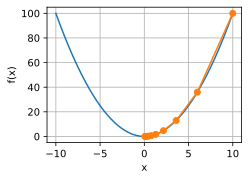

In [3]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)))
    f_line = np.arange(-n, n, 0.01)
    d2l.set_figsize((3.5, 2.5))
    d2l.plot([f_line, res], [[f(x) for x in f_line], [f(x) for x in res]],'x', 'f(x)', fmts=['-', '-o'])

show_trace(res)

## Learning Rate

The learning rate $\eta$ can be set by the algorithm designer. If we use a learning rate that is too small, it will cause $x$ to update very slowly, requiring more iterations to get a better solution. To show what happens in such a case, consider the progress in the same optimization problem for $\eta = 0.05$. As we can see, even after 10 steps we are still very far from the optimal solution.

epoch 10, x: 3.4867844009999995


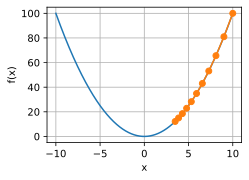

In [4]:
show_trace(gd(0.05))


Conversely, if we use an excessively high learning rate, $\left|\eta f'(x)\right|$ might be too large for the first-order Taylor expansion formula. That is, the term $O(\eta^2 f'^2(x))$ in :eqref:gd-taylor might become significant. In this case, we cannot guarantee that the iteration of $x$ will be able to lower the value of $f(x)$. For example, when we set the learning rate to $\eta=1.1$, $x$ overshoots the optimal solution $x=0$ and gradually diverges.



epoch 10, x: 61.917364224000096


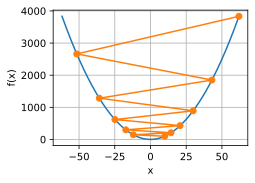

In [5]:
show_trace(gd(1.1))

## Local Minima

To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos c x$. This function has infinitely many local minima. Depending on our choice of learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.

epoch 10, x: -1.528165927635083


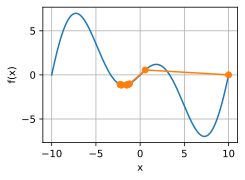

In [6]:
c = 0.15 * math.pi
def f(x):     return x*math.cos(c * x) 
def gradf(x): return math.cos(c * x) - c * x * math.sin(c * x)

show_trace(gd(2))

## Multivariate Gradient Descent

Now that have a better intuition of the univariate case, let us consider the situation where $\mathbf{x} \in \mathbb{R}^d$. That is, the objective function $f: \mathbb{R}^d \to \mathbb{R}$ maps vectors into scalars. Correspondingly its gradient is multivariate, too. It is a vector consisting of $d$ partial derivatives:

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

Each partial derivative element $\partial f(\mathbf{x})/\partial x_i$ in the gradient indicates the rate of change of $f$ at $\mathbf{x}$ with respect to the input $x_i$. As before in the univariate case we can use the corresponding Taylor approximation for multivariate functions to get some idea of what we should do. In particular, we have that

$$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + O(|\mathbf{\epsilon}|^2).$$ :eqlabel:gd-multi-taylor

In other words, up to second order terms in $\mathbf{epsilon}$ the direction of steepest descent is given by the negative gradient $-\nabla f(\mathbf{x})$. Choosing a suitable learning rate $\eta > 0$ yields the prototypical gradient descent algorithm:

$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$

To see how the algorithm behaves in practice let's construct an objective function $f(\mathbf{x})=x_1^2+2x_2^2$ with a two-dimensional vector $\mathbf{x} = [x_1, x_2]^\top$ as input and a scalar as output. The gradient is given by $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$. We will observe the trajectory of $\mathbf{x}$ by gradient descent from the initial position $[-5,-2]$. We need two more helper functions. The first uses an update function and applies it $20$ times to the initial value. The second helper visualizes the trajectory of $\mathbf{x}$.

Next, we observe the trajectory of the optimization variable $\mathbf{x}$ for learning rate $\eta = 0.1$. We can see that after 20 steps the value of $\mathbf{x}$ approaches its minimum at $[0, 0]$. Progress is fairly well-behaved albeit rather slow.

epoch 20, x1 -0.057646, x2 -0.000073


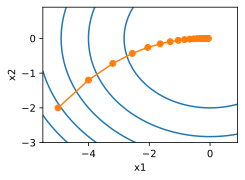

In [7]:
def f(x1, x2): return x1 ** 2 + 2 * x2 ** 2   # objective
def gradf(x1, x2): return (2 * x1, 4 * x2)    # gradient 
def gd(x1, x2, s1, s2): 
    (g1, g2) = gradf(x1, x2)                  # compute gradient
    return (x1 -eta * g1, x2 -eta * g2, 0, 0) # update variables

eta = 0.1
d2l.show_trace_2d(f, d2l.train_2d(gd))

## Adaptive Methods


As we could see in :numref:section_gd-learningrate, getting the learning rate $\eta$ 'just right' is tricky. If we pick it too small, we make no progress. If we pick it too large, the solution oscillates and in the worst case it might even diverge. What if we could determine $\eta$ automatically or get rid of having to select a step size at all? Second order methods that look not only at the value and gradient of the objective but also at its curvature can help in this case. While these methods cannot be applied to deep learning directly due to the computational cost, they provide useful intuition into how to design advanced optimization algorithms that mimic many of the desirable properties of the algorithms outlined below.

### Newton's Method

Reviewing the Taylor expansion of $f$ there's no need to stop after the first term. In fact, we can write it as

$$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \mathbf{\epsilon}^\top \nabla \nabla^\top f(\mathbf{x}) \mathbf{\epsilon} + O(|\mathbf{\epsilon}|^3)$$ :eqlabel:gd-hot-taylor

To avoid cumbersome notation we define $H_f := \nabla \nabla^\top f(\mathbf{x})$ to be the Hessian of $f$. This is a $d \times d$ matrix. For small $d$ and simple problems $H_f$ is easy to compute. For deep networks, on the other hand, $H_f$ may be prohibitively large, due to the cost of storing $O(d^2)$ entries. Furthermore it may be too expensive to compute via backprop as we would need to apply backprop to the backpropagation call graph. For now let us ignore such considerations and look at what algorithm we'd get.

After all, the minimum of $f$ satisfies $\nabla f(\mathbf{x}) = 0$. Taking derivatives of :eqref:gd-hot-taylor with regard to $\mathbf{\epsilon}$ and ignoring higher order terms we arrive at

$$\nabla f(\mathbf{x}) + H_f \mathbf{\epsilon} = 0 \text{ and hence } \mathbf{\epsilon} = -H_f^{-1} \nabla f(\mathbf{x}).$$

That is, we need to invert the Hessian $H_f$ as part of the optimization problem.

For $f(x) = \frac{1}{2} x^2$ we have $\nabla f(x) = x$ and $H_f = 1$. Hence for any $x$ we obtain $\epsilon = -x$. In other words, a single step is sufficient to converge perfectly without the need for any adjustment! Alas, we got a bit lucky here since the Taylor expansion was exact. Let's see what happens in other problems

epoch 10, x: 0.0


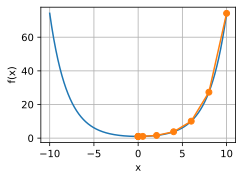

In [8]:
c = 0.5
def f(x):     return math.cosh(c * x)        # objective
def gradf(x): return c * math.sinh(c * x)    # derivative
def hessf(x): return c**2 * math.cosh(c * x) # hessian

# hide learning rate for now
def newton(eta = 1):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x) / hessf(x)
        results.append(x)
    print('epoch 10, x:', x)
    return results

show_trace(newton())

Now let's see what happens when we have a nonconvex function, such as $f(x) = x \cos(c x)$. After all, note that in Newton's method we end up dividing by the Hessian. This means that if the second derivative is negative we would walk into the direction of increasing $f$. That is a fatal flaw of the algorithm. Let's see what happens in practice.

epoch 10, x: 26.83413291324767


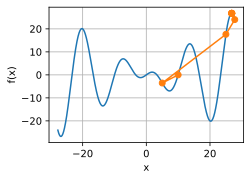

In [9]:
c = 0.15 * math.pi
def f(x):     return x*math.cos(c * x) 
def gradf(x): return math.cos(c * x) - c * x * math.sin(c * x)
def hessf(x): return - 2 * c * math.sin(c * x) - x * c**2 * math.cos(c * x)

show_trace(newton())

This went spectacularly wrong. How can we fix it? One way would be to 'fix' the Hessian by taking its absolute value instead. Another strategy is to bring back the learning rate. This seems to defeat the purpose, but not quite. Having second order information allows us to be cautious whenever the curvature is large and to take longer steps whenever the objective is flat. Let's see how this works with a slightly smaller learning rate, say $\eta = 0.5$. As we can see, we have quite an efficient algorithm.

epoch 10, x: 7.269860168684531


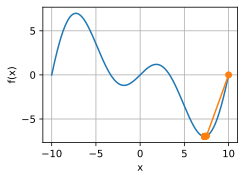

In [10]:
show_trace(newton(0.5))

## Convergence Analysis


We only analyze the convergence rate for convex and three times differentiable $f$, where at its minimum $x^$ the second derivative is nonzero, i.e. where $f''(x^) > 0$. The multivariate proof is a straightforward extension of the argument below and omitted since it doesn't help us much in terms of intuition.

Denote by $x_k$ the value of $x$ at the $k$-th iteration and let $e_k := x_k - x^$ be the distance from optimality. By Taylor series expansion we have that the condition $f'(x^) = 0$ can be written as

$$0 = f'(x_k - e_k) = f'(x_k) - e_k f''(x_k) + \frac{1}{2} e_k^2 f'''(\xi_k).$$

This holds for some $\xi_k \in [x_k - e_k, x_k]$. Recall that we have the update $x_{k+1} = x_k - f'(x_k) / f''(x_k)$. Dividing the above expansion by $f''(x_k)$ yields

$$e_k - f'(x_k) / f''(x_k) = \frac{1}{2} e_k^2 f'''(\xi_k) / f'(x_k)$$

Plugging in the update equations leads to the following bound $e_{k+1} \leq e_k^2 f'''(\xi_k) / f'(x_k)$. Consequently, whenever we are in a region of bounded $f'''(\xi_k) / f'(x_k) \leq c$, we have a quadratically decreasing error $e_{k+1} \leq c e_k^2$.

As an aside, optimization researchers call this linear convergence, whereas a condition such as $e_{k+1} \leq \alpha e_k$ would be called a constant rate of convergence. Note that this analysis comes with a number of caveats: We don't really have much of a guarantee when we will reach the region of rapid convergence. Instead, we only know that once we reach it, convergence will be very quick. Second, this requires that $f$ is well-behaved up to higher order derivatives. It comes down to ensuring that $f$ doesn't have any 'surprising' properties in terms of how it might change its values.

## Preconditioning


Quite unsurprisingly computing and storing the full Hessian is very expensive. It is thus desirable to find alternatives. One way to improve matters is by avoiding to compute the Hessian in its entirety but only compute the diagonal entries. While this isn't quite as good as the full Newton method, it is still much better than not using it. Moreover, estimates for the main diagonal elements are what drives some of the innovation in stochastic gradient descent optimization algorithms. This leads to update algorithms of the form

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(H_f)^{-1} \nabla \mathbf{x}.$$

To see why this might be a good idea consider a situation where one variable denotes height in milimeters and the other one denotes height in kilometers. Assuming that for both the natural scale is in meters we have a terrible mismatch in parametrizations. Using preconditioning removes this. Effectively preconditioning with gradient descent amounts to selecting a different learning rate for each coordinate.

## Gradient Descent with Line Search

One of the key problems in gradient descent was that we might overshoot the goal or make insufficient progress. A simple fix for the problem is to use line search in conjunction with gradient descent. That is, we use the direction given by $\nabla f(\mathbf{x})$ and then perform binary search as to which steplength $\eta$ minimizes $f(x - \eta \nabla f(\mathbf{x}))$.

This algorithm converges rapidly (for an analysis and proof see e.g. :cite:Boyd.Vandenberghe.2004). However, for the purpose of deep learning this isn't quite so feasible, since each step of the line search would require us to evaluate the objective function on the entire dataset. This is way too costly to accomplish.

## Exercises

1. Experiment with different learning rates and objective functions for gradient descent.
2. Implement line search to minimize a convex function in the interval $[a, b]$.
   - Do you need derivatives for binary search, i.e. to decide whether to pick $[a, (a+b)/2]$ or $[(a+b)/2, b]$.
   - How rapid is the rate of convergence for the algorithm?
   - Implement the algorithm and apply it to minimizing $\log (\exp(x) + \exp(-2*x -3))$.
3. Design an objective function defined on $\mathbb{R}^2$ where gradient descent is exceedingly slow. Hint - scale different coordinates differently.
4. Implement the lightweight version of Newton's method using preconditioning:
   - Use diagonal Hessian as preconditioner.
   - Use the absolute values of that rather than the actual (possibly signed) values.
   - Apply this to the problem above.
5. Apply the algorithm above to a number of objective functions (convex or not). What happens if you rotate coordinates by $45$ degrees?